In [9]:
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
from datetime import date
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [14]:
#重新读取数据，将null原样保持，方便处理
off_train = pd.read_csv('data/ccf_offline_stage1_train.csv',keep_default_na=False)
off_train.columns=['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']
off_test = pd.read_csv('data/ccf_offline_stage1_test_revised.csv',keep_default_na=False)
off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']
on_train = pd.read_csv('data/ccf_online_stage1_train.csv',keep_default_na=False)
on_train.columns = ['user_id','merchant_id','action','coupon_id','discount_rate','date_received','date']
off_train[['user_id','merchant_id','coupon_id']]=off_train[['user_id','merchant_id','coupon_id']].astype(str)
off_test[['user_id','merchant_id','coupon_id']]=off_test[['user_id','merchant_id','coupon_id']].astype(str)
on_train[['user_id','merchant_id','coupon_id']]=on_train[['user_id','merchant_id','coupon_id']].astype(str)

In [15]:
#查看online offline 训练集的 user_id与测试集的重合度
off_train_user=off_train[['user_id']].copy().drop_duplicates()
off_test_user=off_test[['user_id']].copy().drop_duplicates()
on_train_user=on_train[['user_id']].copy().drop_duplicates()
print ('offline 训练集用户ID数量')
print (off_train_user.user_id.count())
print ('online 训练集用户ID数量')
print (on_train_user.user_id.count())
print ('offline 测试集用户ID数量')
print (off_test_user.user_id.count())
off_train_user['off_train_flag']=1
off_merge=off_test_user.merge(off_train_user,on='user_id', how="left").reset_index().fillna(0)
print ('offline 训练集用户与测试集用户重复数量')
print(off_merge['off_train_flag'].sum())
print ('offline 训练集用户与测试集重复用户在总测试集用户中的占比')
print(off_merge['off_train_flag'].sum()/off_merge['off_train_flag'].count())
on_train_user['on_train_flag']=1
on_merge=off_test_user.merge(on_train_user,on='user_id', how="left").reset_index().fillna(0)
print ('online 训练集用户与测试集用户重复数量')
print(on_merge['on_train_flag'].sum())
print ('online 训练集用户与测试集重复用户在总测试集用户中的占比')
print(on_merge['on_train_flag'].sum()/on_merge['on_train_flag'].count())

offline 训练集用户ID数量
539438
online 训练集用户ID数量
762858
offline 测试集用户ID数量
76309
offline 训练集用户与测试集用户重复数量
76307.0
offline 训练集用户与测试集重复用户在总测试集用户中的占比
0.9999737907717308
online 训练集用户与测试集用户重复数量
43155.0
online 训练集用户与测试集重复用户在总测试集用户中的占比
0.5655296229802513


In [16]:
#查看online offline 训练集的 merchant_id 与测试集的重合度
off_train_merchant=off_train[['merchant_id']].copy().drop_duplicates()
off_test_merchant=off_test[['merchant_id']].copy().drop_duplicates()
on_train_merchant=on_train[['merchant_id']].copy().drop_duplicates()
print ('offline 训练集商家ID数量')
print (off_train_merchant.merchant_id.count())
print ('online 训练集商家ID数量')
print (on_train_merchant.merchant_id.count())
print ('offline 测试集商家ID数量')
print (off_test_merchant.merchant_id.count())

off_train_merchant['off_train_flag']=1
off_merge=off_test_merchant.merge(off_train_merchant,on='merchant_id', how="left").reset_index().fillna(0)
print ('offline 训练集商家与测试集商家重复数量')
print(off_merge['off_train_flag'].sum())
print ('offline 训练集商家与测试集重复商家在总测试集商家中的占比')
print(off_merge['off_train_flag'].sum()/off_merge['off_train_flag'].count())

on_train_merchant['on_train_flag']=1
on_merge=off_test_merchant.merge(on_train_merchant,on='merchant_id', how="left").reset_index().fillna(0)
print ('online 训练集商家与测试集商家重复数量')
print(on_merge['on_train_flag'].sum())
print ('online 训练集商家与测试集重复商家在总测试集商家中的占比')
print(on_merge['on_train_flag'].sum()/on_merge['on_train_flag'].count())

offline 训练集商家ID数量
8415
online 训练集商家ID数量
7999
offline 测试集商家ID数量
1559
offline 训练集商家与测试集商家重复数量
1558.0
offline 训练集商家与测试集重复商家在总测试集商家中的占比
0.9993585631815266
online 训练集商家与测试集商家重复数量
0.0
online 训练集商家与测试集重复商家在总测试集商家中的占比
0.0


In [17]:
#分隔符
separator=':'
#计算折扣率，将满减和折扣统一
#因为discount_rate为null的时候一般都是没有使用优惠券，这个时候折扣应该是1
def get_discount_rate(s):
    s = str(s)
    if s=='null':
        return -1
        #return 1
    s = s.split(separator)
    if len(s) == 1:
        return float(s[0])
    else:
        return 1.0-float(s[1])/float(s[0])

#获取是否满减（full reduction promotion）
def get_if_fd(s):
    s = str(s)
    s = s.split(separator)
    if len(s)==1:
        return 0
    else:
        return 1

#获取满减的条件
def get_full_value(s):
    s = str(s)
    s = s.split(separator)
    if len(s)==1:
        return -1
    else:
        return int(s[0])

#获取满减的优惠
def get_reduction_value(s):
    s = str(s)
    s = s.split(separator)
    if len(s) == 1:
        return -1
    else:
        return int(s[1])


#获取月份
def get_month(s):
    if s[0]=='null':
        return -1
    else:
        return int(s[4:6])

#获取日期
def get_day(s):
    if s[0]=='null':
        return -1
    else:
        return int(s[6:8])

#获取日期间隔输入内容为Date:Date_received
def get_day_gap(s):
    s = s.split(separator)
    if s[0]=='null':
        return -1
    if s[1]=='null':
        return -1
    else:
        return (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8])) - date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days

#获取Label，输入内容为Date:Date_received
def get_label(s):
    s = s.split(separator)
    if s[0]=='null':
        return 0
    if s[1]=='null':
        return -1
    elif (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8]))-date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days<=15:
        return 1
    else:
        return -1

In [18]:
def add_feature(df):
    df['if_fd']=df['discount_rate'].apply(get_if_fd)
    df['full_value']=df['discount_rate'].apply(get_full_value)
    df['reduction_value']=df['discount_rate'].apply(get_reduction_value)
    df['discount_rate']=df['discount_rate'].apply(get_discount_rate)
    df['distance']=df['distance'].replace('null',-1).astype(int)
    #df['month_received'] = df['date_received'].apply(get_month)
    #df['month'] = df['date'].apply(get_month)
    return df

def add_label(df):
    df['day_gap']=df['date'].astype('str') + ':' +  df['date_received'].astype('str')
    df['label']=df['day_gap'].apply(get_label)
    df['day_gap']=df['day_gap'].apply(get_day_gap)
    return df

In [19]:
dftrain = off_train.copy()
dftest = off_test.copy()
dftrain=add_feature(dftrain)
dftrain=add_label(dftrain)
dftest=add_feature(dftest)

null       701602
30:5       270712
100:10     182554
200:20     111046
20:5        91013
20:1        51705
50:5        47379
100:30      38196
200:30      29327
300:30      28979
50:10       28452
10:5        25925
0.95        20568
10:1        17842
30:1        17654
150:20      17437
100:20      14297
30:10       12692
50:20        8203
0.9          8085
200:50       5585
150:10       5325
100:5        5053
0.8          3441
50:1         3354
5:1          2526
100:50       1774
150:30        654
0.85          649
200:10        575
100:1         537
20:10         514
150:50        306
300:50        206
0.5           186
0.75          121
0.2           110
0.6            58
200:5          57
300:20         56
0.7            54
30:20          24
300:10         23
200:100        12
50:30           9
150:5           7
Name: discount_rate, dtype: int64


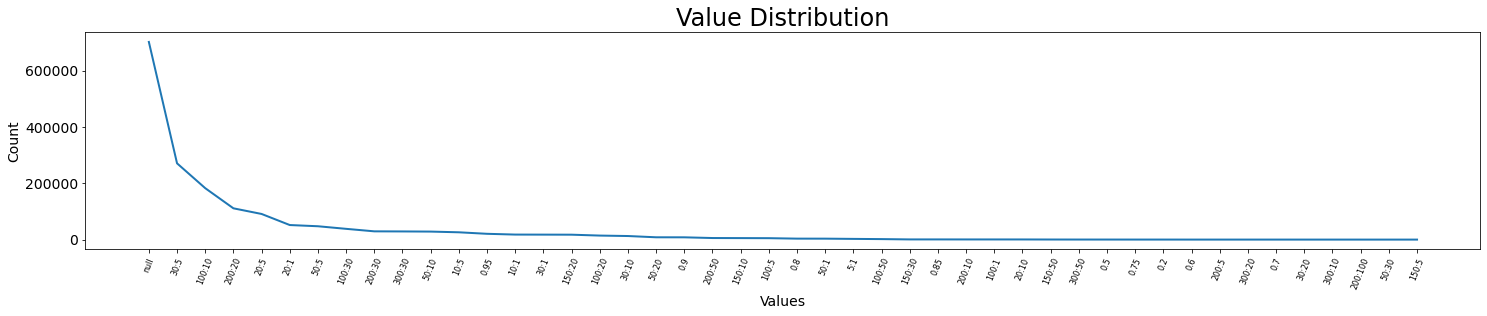

In [21]:
dftrain.head()
print(off_train["discount_rate"].value_counts())

plt.rcParams['figure.figsize'] = (25.0, 4.0)
plt.title("Value Distribution", fontsize=24)
plt.xlabel("Values", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.xticks(size="small", rotation=68, fontsize=8)
plt.plot(off_train['discount_rate'].value_counts(), linewidth=2)
plt.show()

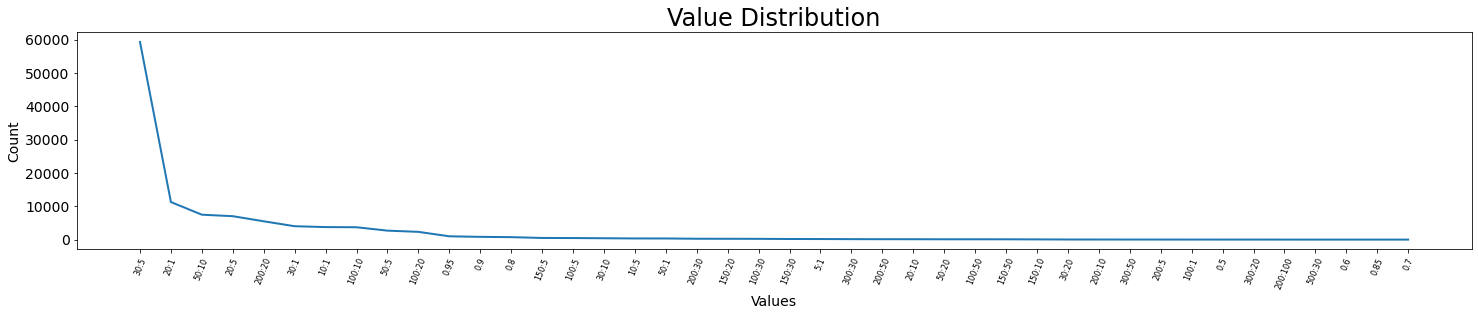

In [22]:
plt.rcParams['figure.figsize'] = (25.0, 4.0)
plt.title("Value Distribution", fontsize=24)
plt.xlabel("Values", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.xticks(size="small", rotation=68, fontsize=8)
plt.plot(off_test['discount_rate'].value_counts(), linewidth=2)
plt.show()

<AxesSubplot:xlabel='distance'>

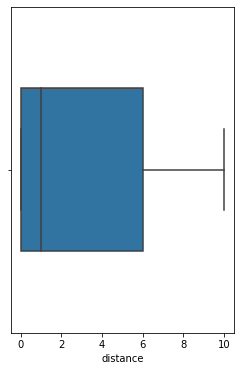

In [24]:
fig = plt.figure(figsize=(4, 6))
sns.boxplot(dftrain[(dftrain.label >= 0) & (dftrain.distance >= 0)]['distance'],
            orient="h", width=0.5)

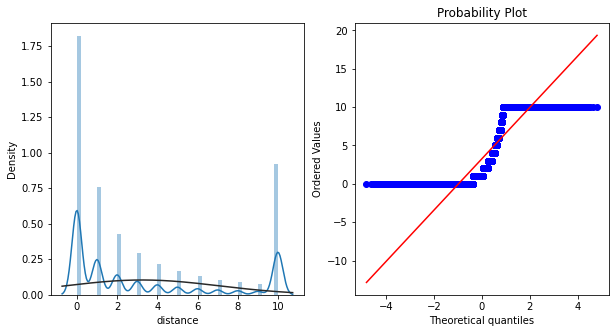

In [26]:
plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 2, 1)
sns.distplot(dftrain[(dftrain.label>=0) & (dftrain.distance>=0)]['distance'], fit=stats.norm)
ax = plt.subplot(1, 2, 2)
res = stats.probplot(dftrain[(dftrain.label>=0) & (dftrain.distance>=0)]['distance'], plot=plt)

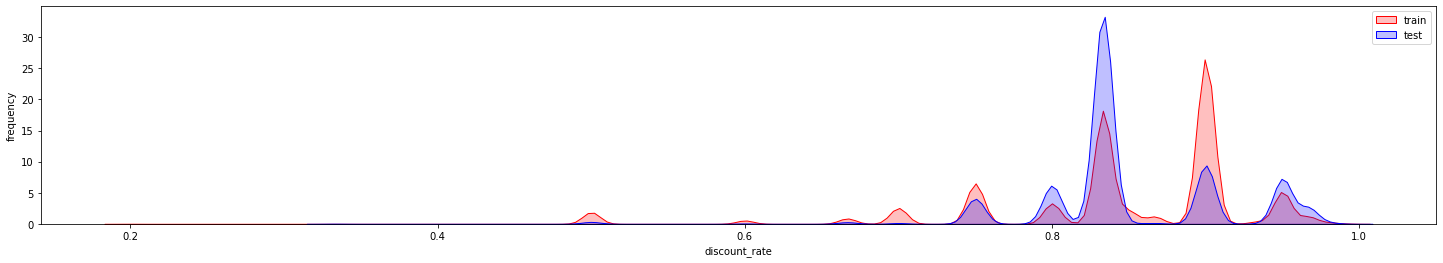

In [29]:
ax = sns.kdeplot(dftrain[(dftrain.label>=0) &
                         (dftrain.discount_rate>=0)]['discount_rate'],
                 color="Red", shade=True)
ax = sns.kdeplot(dftest[(dftest.discount_rate>=0)]['discount_rate'],
                 color="Blue", shade=True)
ax.set_xlabel("discount_rate")
ax.set_ylabel("frequency")
ax = ax.legend(["train", "test"])

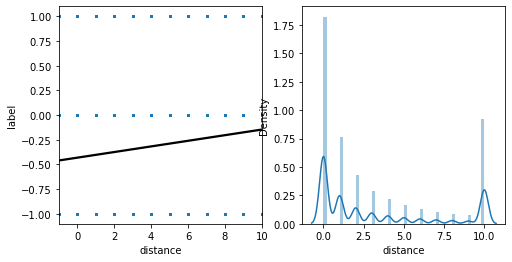

In [30]:
fcols = 2
frows = 1
plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
sns.regplot(x='distance', y='label',
            data=dftrain[(dftrain.label>=0) & dftrain.distance>=0][[
                "distance", "label"
            ]],
            ax=ax,
            scatter_kws={
                'marker': ".",
                "s": 3,
                "alpha": 0.3
            },
            line_kws={'color': 'k'})
plt.xlabel('distance')
plt.ylabel('label')
ax = plt.subplot(1, 2, 2)
sns.distplot(dftrain[(dftrain.label>=0) &
                     (dftrain.distance>=0)]["distance"].dropna())
plt.xlabel("distance")
plt.show()